In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Define class names
class_names=['Apple__Apple_scab','Apple__Black_rot','Apple___Cedar_apple_rust','Apple___Healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot']
class_names_label={class_name: i for i, class_name in enumerate(class_names)}
nb_classes=len(class_names)
IMAGE_SIZE=(150,150)
BATCH_SIZE=32

In [4]:
#Define transformations (data preprocessing)
transform=transforms.Compose([transforms.Resize(IMAGE_SIZE),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [5]:
#Load datasets
train_dataset=datasets.ImageFolder(root='/content/drive/MyDrive/workshop2/plant disease using CNN/train',transform=transform)
test_dataset=datasets.ImageFolder(root='/content/drive/MyDrive/workshop2/plant disease using CNN/test',transform=transform)

In [6]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [7]:
# Check dataset size
n_train = len(train_dataset)
n_test = len(test_dataset)

print(f"Number of training examples: {n_train}")
print(f"Number of testing examples: {n_test}")
print(f"Each image is of size: {IMAGE_SIZE}")

Number of training examples: 106
Number of testing examples: 106
Each image is of size: (150, 150)


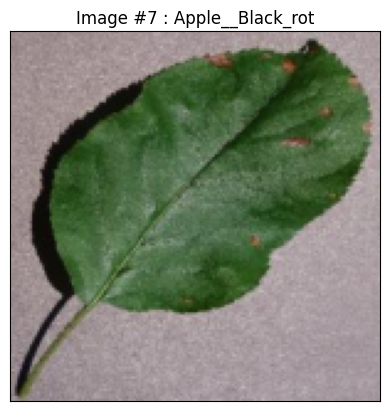

In [8]:
#visualising the dataset
def display_random_image(loader,class_names):
  dataiter=iter(loader)
  images,labels=next(dataiter)
  index=np.random.randint(len(labels))
  image=images[index].numpy().transpose(1,2,0)
  image=image*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406])
  image=np.clip(image,0,1)
  plt.figure()
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(f'Image #{index} : {class_names[labels[index]]}')
  plt.show()
display_random_image(train_loader,class_names)

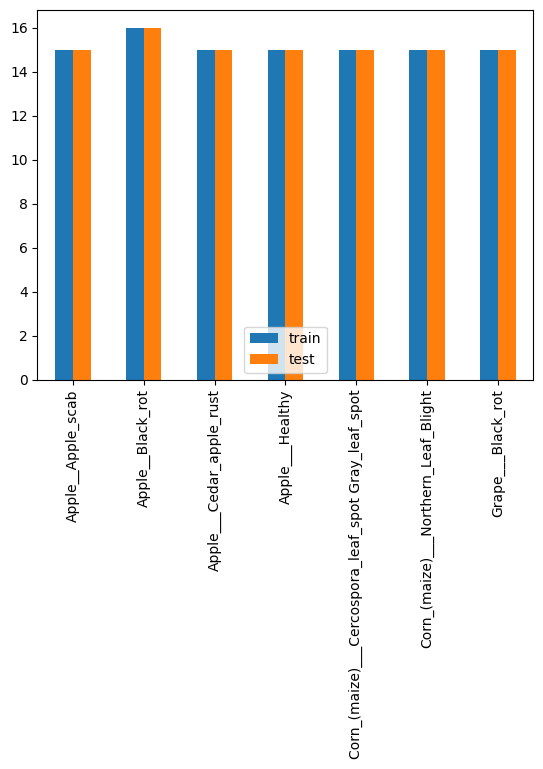

In [9]:
# Plotting dataset distribution
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test': test_counts}, index=class_names).plot.bar()
plt.show()

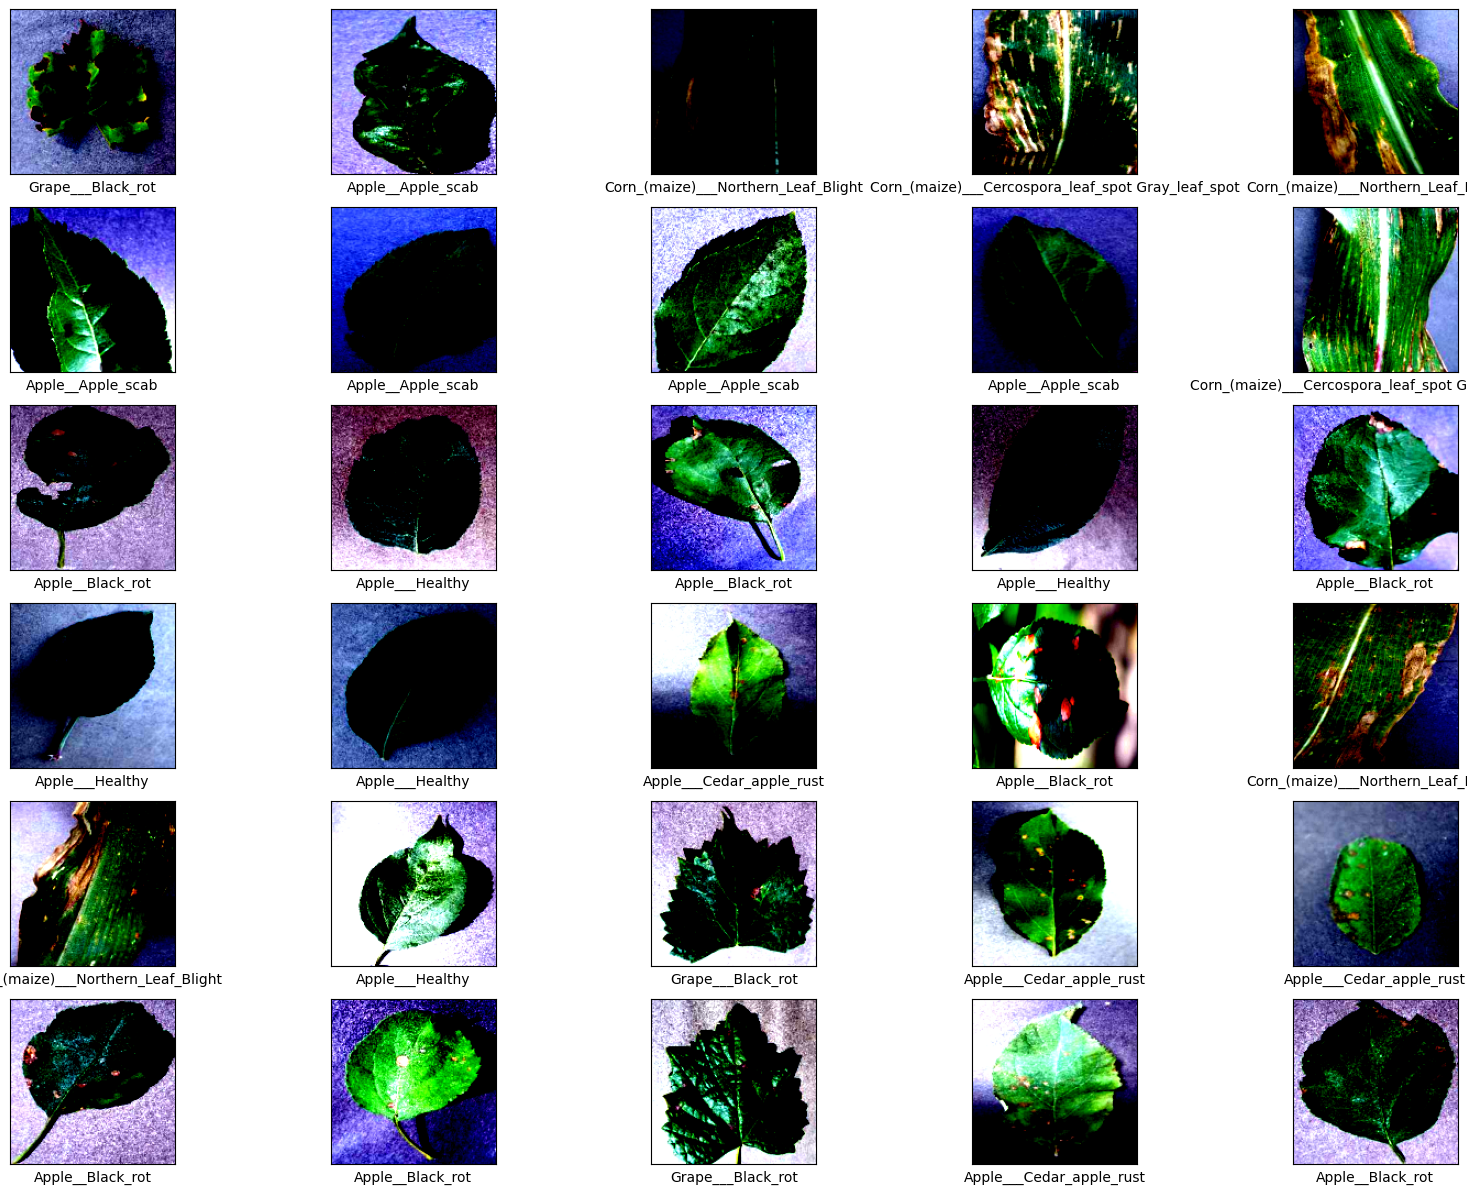

In [10]:
def display_examples(class_names, loader):
    num_examples = 30
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(20, 15))
    for i in range(min(num_examples, len(images))):
        plt.subplot(6, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Convert tensor to numpy and clip values to [0, 1] range for imshow
        image = images[i].numpy().transpose(1, 2, 0)
        image = np.clip(image, 0, 1)  # Clipping values to the valid range

        plt.imshow(image)
        plt.xlabel(class_names[labels[i].item()])
    plt.show()
display_examples(class_names,train_loader)

In [11]:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    import torchvision.transforms as transforms

    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 input channels for RGB images
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=0.5)

            # Calculate the size of the flattened feature vector
            self.flattened_size = self._get_flattened_size()

            # Define fully connected layers
            self.fc1 = nn.Linear(self.flattened_size, 128)  # Adjust based on the flattened size
            self.fc2 = nn.Linear(128, len(class_names))  # Output size is the number of classes

        def _get_flattened_size(self):
            # Use a dummy tensor to calculate the size after conv and pool layers
            with torch.no_grad():
                x = torch.zeros(1, 3, 150, 150)  # Input image size
                x = self.conv1(x)
                x = self.relu(x)
                x = self.pool(x)
                x = self.conv2(x)
                x = self.relu(x)
                x = self.pool(x)
                return x.view(-1).size(0)

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.relu(x)
            x = self.pool(x)
            x = x.view(-1, self.flattened_size)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Hyperparameters
    batch_size = 32  # Adjust batch size according to your dataset and GPU/CPU memory
    learning_rate = 0.001
    num_epochs = 5

    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load datasets
    trainset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/workshop2/plant disease using CNN/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/workshop2/plant disease using CNN/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Define class names
    class_names = trainset.classes  # Get class names from the dataset

    # Initialize the model, loss function, and optimizer
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

    print('Finished Training')

    # Testing the model
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Finished Training
Accuracy of the network on the test images: 61 %
